# 🌿 Plant Disease Classifier

This notebook trains a ResNet18 model to detect plant diseases using the PlantVillage dataset. It includes data loading, transfer learning, evaluation, and visualization of predictions.

We'll walk through:
- Loading and preprocessing image data
- Transfer learning with a pretrained ResNet18
- Evaluation using a confusion matrix and sample misclassifications


## ⚙️ Imports & Setup
Includes device detection and logging (MPS, CPU fallback).

In [1]:
# Standard library imports
import random
import collections

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix

# Local imports
from plant_disease_classifier.config import (
    DEVICE, IMG_SIZE, DATA_DIR, BATCH_SIZE, 
    EPOCHS, LEARNING_RATE, MODEL_PATH
)

ModuleNotFoundError: No module named 'plant_disease_classifier'

## 🧪 Data Transforms & Loaders
- Standard augmentations for training
- Use torchvision.datasets.ImageFolder

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(DATA_DIR / "train", transform=train_transforms)
val_dataset = datasets.ImageFolder(DATA_DIR / "val", transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

## 🖼 Data Preview
- Plot class distribution
- Show sample images with labels

In [5]:
class_names = train_dataset.classes
for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")

0: Pepper__bell___Bacterial_spot
1: Pepper__bell___healthy
2: Potato___Early_blight
3: Potato___Late_blight
4: Potato___healthy
5: Tomato_Bacterial_spot
6: Tomato_Early_blight
7: Tomato_Late_blight
8: Tomato_Leaf_Mold
9: Tomato_Septoria_leaf_spot
10: Tomato_Spider_mites_Two_spotted_spider_mite
11: Tomato__Target_Spot
12: Tomato__Tomato_YellowLeaf__Curl_Virus
13: Tomato__Tomato_mosaic_virus
14: Tomato_healthy


In [6]:
# Plot Class Distribution
print("Generating class distribution plot...")
# Get class counts
# train_dataset.targets contains the class index for each sample in the dataset
if hasattr(train_dataset, 'targets') and train_dataset.targets:
    class_counts = collections.Counter(train_dataset.targets)
    
    # Prepare data for plotly bar chart
    # Sort by class index to ensure order matches class_names
    sorted_class_indices = sorted(class_counts.keys())
    
    names_for_plot = [class_names[i] for i in sorted_class_indices]
    counts_for_plot = [class_counts[i] for i in sorted_class_indices]

    dist_fig = go.Figure(go.Bar(
        x=names_for_plot,
        y=counts_for_plot,
        text=counts_for_plot,
        textposition='outside', # Show count values outside the bars
        marker_color=px.colors.qualitative.Plotly # Use a default Plotly color sequence
    ))
    dist_fig.update_layout(
        title_text='Class Distribution in Training Set',
        xaxis_title='Class Name',
        yaxis_title='Number of Images',
        xaxis_tickangle=-45,
        height=500,
        margin=dict(b=150) # Increase bottom margin if class names are long
    )
    dist_fig.show()
else:
    print("Could not plot class distribution: train_dataset.targets is empty or not available.")

Generating class distribution plot...


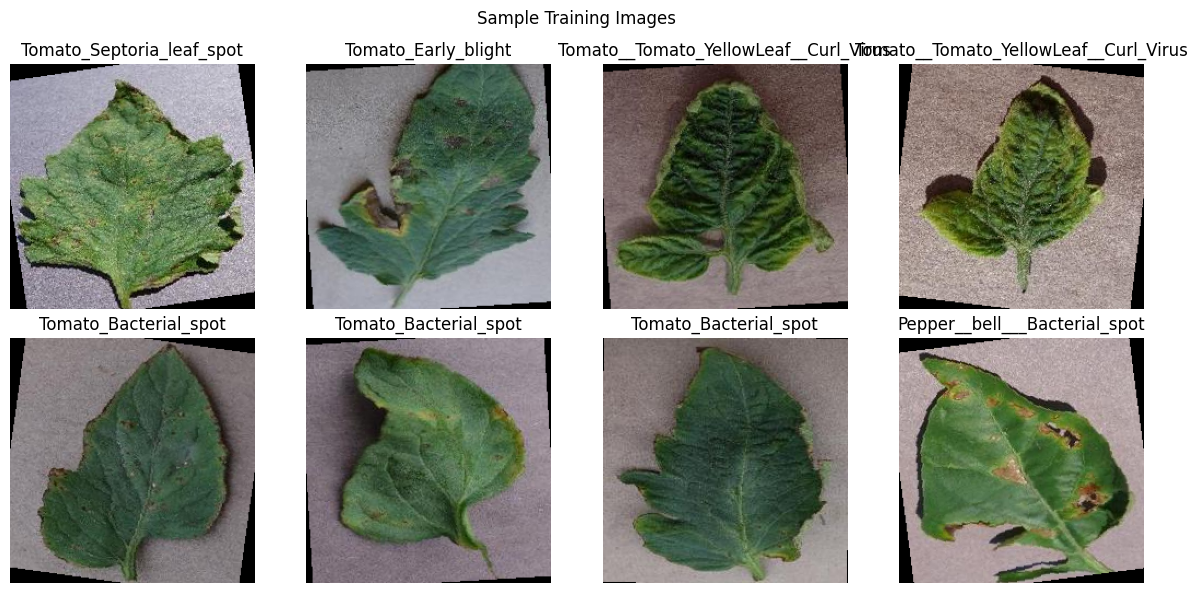

In [7]:
# Display sample images from training dataset
imgs, labels = zip(*[train_dataset[i] for i in random.sample(range(len(train_dataset)), 8)])
plt.figure(figsize=(12, 6))
for i, (img, label) in enumerate(zip(imgs, labels)):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis("off")
plt.suptitle("Sample Training Images")
plt.tight_layout()
plt.show()

## 🧠 Model Initialization
- Load pretrained ResNet18
- Replace final layer

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


/Users/jesse/Library/Caches/pypoetry/virtualenvs/plant-disease-classifier-3-w0E3XD-py3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/Users/jesse/Library/Caches/pypoetry/virtualenvs/plant-disease-classifier-3-w0E3XD-py3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.



## 🔁 Training Loop
- Epoch loop with loss + accuracy
- Live training curves
- Save the best model as it is trained

In [ ]:
train_losses, val_accuracies = [], []
best_val_acc = 0.0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_losses.append(running_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {running_loss:.4f} - Train Acc: {train_acc:.4f}")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_PATH)
        print("Saved new best model")

print(f"Best Validation Accuracy: {best_val_acc:.4f}")


Epoch 1/10 - Train Loss: 136.0476 - Train Acc: 0.9276
Epoch 1/10 - Val Acc: 0.9843
Saved new best model
Epoch 2/10 - Train Loss: 29.7027 - Train Acc: 0.9835
Epoch 2/10 - Val Acc: 0.9867
Saved new best model
Epoch 3/10 - Train Loss: 19.8770 - Train Acc: 0.9887
Epoch 3/10 - Val Acc: 0.9908
Saved new best model
Epoch 4/10 - Train Loss: 11.2145 - Train Acc: 0.9947
Epoch 4/10 - Val Acc: 0.9845
Epoch 5/10 - Train Loss: 16.8569 - Train Acc: 0.9896
Epoch 5/10 - Val Acc: 0.9852
Epoch 6/10 - Train Loss: 13.4482 - Train Acc: 0.9920
Epoch 6/10 - Val Acc: 0.9872
Epoch 7/10 - Train Loss: 12.1228 - Train Acc: 0.9925
Epoch 7/10 - Val Acc: 0.9932
Saved new best model
Epoch 8/10 - Train Loss: 9.1708 - Train Acc: 0.9950
Epoch 8/10 - Val Acc: 0.9901
Epoch 9/10 - Train Loss: 9.6116 - Train Acc: 0.9938
Epoch 9/10 - Val Acc: 0.9959
Saved new best model


KeyboardInterrupt: 

In [20]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Training Loss", "Validation Accuracy"))

fig.add_trace(
    go.Scatter(y=train_losses, name="Train Loss"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(y=val_accuracies, name="Val Accuracy"),
    row=1, col=2
)

fig.update_layout(height=400, width=1000, title_text="Training Metrics")
fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_xaxes(title_text="Epoch", row=1, col=2)
fig.update_yaxes(title_text="Loss", row=1, col=1)
fig.update_yaxes(title_text="Accuracy", row=1, col=2)
fig.show()


## 📊 Confusion Matrix

In [ ]:
# Collect predictions and true labels from the validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute and display confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))
fig = go.Figure(data=go.Heatmap(
    z=cm,
    x=class_names,
    y=class_names,
    colorscale='Blues',
    text=cm,
    texttemplate='%{text}',
    textfont={"size": 10},
    showscale=False
))

fig.update_layout(
    title="Validation Set Confusion Matrix",
    xaxis_title="Predicted",
    yaxis_title="True",
    xaxis={'tickangle': 90},
    height=800,
    width=800
)

fig.show()

NameError: name 'model' is not defined

## 🔍 Misclassification Analysis

In [ ]:
class_names = train_dataset.classes
misclassified_indices = [i for i, (pred, true) in enumerate(zip(all_preds, all_labels)) if pred != true]
misclassified_images = [train_dataset[i][0] for i in misclassified_indices]

misclassified_labels = [(class_names[all_labels[i]], class_names[all_preds[i]]) for i in misclassified_indices]
misclassified_labels_unique, misclassified_counts = np.unique(misclassified_labels, return_counts=True, axis=0)

print("Misclassified labels and counts [true, predicted]:")
for label, count in zip(misclassified_labels_unique, misclassified_counts):
    print(f"{label}: {count}")

# Choose number of misclassified images to display
num_samples_to_show = min(8, len(misclassified_indices))

if num_samples_to_show > 0:
    indices_to_show = np.random.choice(misclassified_indices, num_samples_to_show, replace=False)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle("Misclassified Images from Validation Set", fontsize=16)

    for ax, idx in zip(axes.flatten(), indices_to_show):
        img_tensor = train_dataset[idx][0]
        img = img_tensor.permute(1, 2, 0).numpy()
        true_label = class_names[all_labels[idx]]
        pred_label = class_names[all_preds[idx]]

        ax.imshow(img)
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
        ax.axis("off")

    # Turn off any unused axes
    for ax in axes.flatten()[len(indices_to_show):]:
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    plt.show()
else:
    print("No misclassified images to show.")

NameError: name 'all_preds' is not defined

## 🔎 Inference Demo


In [ ]:
def predict_image(image_path):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ])
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
    print(f"Predicted class: {class_names[predicted.item()]}")
    return image

predict_image("../data_processed/val/Tomato___Target_Spot/00abc.jpg")

## 🚧 Limitations & Next Steps


The most frequent confusion is mistaking target spot as tomato spider mites. Though infrequent, the implications are important. Target spot calls for an antifungal regiment while spider mites require insecticide or miticide. A follow-up classification may be wise in the absence of other signs such as spider mite webs.

While the performance of this model is excellent, it is not ready for deployment. Photos were taken in ideal lighting against a neutral background. Further collection of labeled images must be conducted in real-world settings, i.e., within the context of the entire plant in the background or even individual leaves in a person's hand.




## ✅ Summary

- Trained a ResNet18 model on the PlantVillage dataset (~50,000+ leaf images)
- Live training visualization with matplotlib
- Achieved classification with confusion matrix insights
- Identified real-world misclassification risks (e.g., Target Spot vs. Spider Mites)
- Model saved to `.pth` and ready for deployment via FastAPI or Streamlit